# Feature Visualization

## Copyright notice

This version (c) 2021 Fabian Offert, [MIT License](LICENSE).

## Colab Setup

Run the below commands only if you imported this notebook into Google Colab! Also **go to Runtime/Change runtime type and pick "GPU" as the hardware accelerator!**

In [6]:
!rm -rf minimal # In case this is re-run
!git clone https://github.com/zentralwerkstatt/minimal
!cp ./minimal/*synset_words.txt ./

Cloning into 'minimal'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [7]:
!nvidia-smi # Check what kind of GPU we got

Thu May  6 12:40:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   2099MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

We are using PyTorch as our deep learning framework.

In [8]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

import numpy as np

from scipy.ndimage.filters import gaussian_filter, median_filter
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle
import PIL.Image, PIL.ImageChops

import os
import random
from io import BytesIO
from IPython import display

## Model to investigate

**Colab users note: this may take a while, as the pre-trained weights have to be loaded in the background!**

In [9]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu") # Use GPU if available
f1 = tv.models.inception_v3(pretrained=True).to(device)
f2 = tv.models.vgg16(pretrained=True).to(device)
f3 = tv.models.vgg19(pretrained=True).to(device)
# Test mode: we do not want to train the model (i.e. change its weights) at any point
f1.eval()
f2.eval()
f3.eval()
model_names = {'f1':'Inception V3', 'f2':'VGG16', 'f3': 'VGG19'}

## Helper functions

Among other things, these helper functions allow us to convert between PyTorch tensors, NumPy arrays, and PIL images.

In [10]:
# Show an image within a Jupyter environment
# Can do PyTorch tensors, NumPy arrays, and PIL images
def show_img(img, title='', fmt='jpeg'):
    if type(img) is np.ndarray:
        img = PIL.Image.fromarray(img)
    elif type(img) is t.Tensor:
        img = deprocess(img)
    out = BytesIO()
    if title: print(title)
    img.save(out, fmt)
    display.display(display.Image(data=out.getvalue()))

# PyTorch is channels first, this happens here!
preprocess = tv.transforms.Compose([tv.transforms.ToTensor()])
    
# Reverse of preprocess, PyTorch tensor to PIL image
def deprocess(tensor):
    # Clone tensor first, otherwise we are NOT making a copy by using .cpu()!
    img = t.clone(tensor)
    img = img.cpu().data.numpy().squeeze() # Get rid of batch dimension
    img = img.transpose((1, 2, 0)) # Channels first to channels last
    
    # We are not using ImageNet images as input
    # mean = np.array([0.485, 0.456, 0.406]) 
    # std = np.array([0.229, 0.224, 0.225]) 
    # img = std * img + mean

    # No clipping, adversarial regulation should take care of this
    # img = np.clip(img, 0, 1)
    
    # 0./1. range to 0./255. range
    img *= 255
    
    img = img.astype(np.uint8)
    img = PIL.Image.fromarray(img)
    return img

# Return a gray square PIL image
def gray_square(size):
    # Gray square, -1./1. range
    img = np.random.normal(0, 0.01, (size, size, 3)) 
    
    # -1./1. range to 0./255. range
    img /= 2.
    img += 0.5
    img *= 255.

    img = img.astype(np.uint8)
    img = PIL.Image.fromarray(img)
    return img

# Load ImageNet classes
with open('synset_words.txt') as synset_words_file:
    synset_words = synset_words_file.readlines()
for i, line in enumerate(synset_words):
    synset_words[i] = line.replace(' ', '_').replace(',', '_').lower().strip()

# Classify an image with the target model 
# Can do PyTorch tensors and PIL images
def predict(img, model):
    if type(img) is t.Tensor:
        preds = model(img.to(device))
    else:
        preds = model(preprocess(img).unsqueeze(0).to(device))
    preds_softmax_np = F.softmax(preds, dim=1).cpu().data.numpy()
    # Returns class no., class name, and prediction confidence
    return preds_softmax_np.argmax(), synset_words[preds_softmax_np.argmax()], preds_softmax_np.max()

# "Rolling" list: whenever an item is added, the first item is discarded
def destructive_append(l,i):
    l=l[1:]
    l.append(i)
    return l

# PyTorch and skimage use different channel ordering
def pytorch_to_skimage(img):
    # No batch dimension
    img = img[0]
    # Channels last
    img = np.swapaxes(img, 0, 2)
    return img
    
def skimage_to_pytorch(img):
    # Channels first
    img = np.swapaxes(img, 0, 2)
    # Skimage uses double
    img = img.astype(np.float32)
    # No Batch dimension
    img = np.expand_dims(img, 0)
    return img

# Filters for feature visualization
def filter_median(npimg, params):
    npimg = median_filter(npimg, size=(1, 1, params['fsize'], params['fsize']))  
    return npimg

def filter_bilateral(npimg, params):
    npimg = pytorch_to_skimage(npimg)
    npimg = denoise_bilateral(npimg, sigma_color=0.05, sigma_spatial=15, multichannel=True)
    npimg = skimage_to_pytorch(npimg)
    return npimg

def filter_TV(npimg, params):
    npimg = pytorch_to_skimage(npimg)
    npimg = denoise_tv_chambolle(npimg, weight=0.1, multichannel=True)
    npimg = skimage_to_pytorch(npimg)
    return npimg

## Gradient Ascent

In [11]:
def gradient_ascent(img, neuron, model):

    ITERATIONS = 2000
    # FILTERS = [{'function':filter_median, 'frequency':4, 'params':{'fsize':5}}] # Good parameters
    FILTERS = [{'function':filter_TV, 'frequency':20, 'params':{}}] # Good parameters
    JITTER = 32
    LR = 0.4
    L2 = 1e-4 # Yosinski weight decay
            
    input = preprocess(img).unsqueeze(0).to(device).requires_grad_()
    optimizer = t.optim.SGD([input], lr=LR, weight_decay=L2)
    
    for i in range(ITERATIONS):
        
        optimizer.zero_grad()
        
        # Centers the object in the image
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            ox, oy = np.random.randint(-JITTER, JITTER+1, 2)
            npimg = np.roll(np.roll(npimg, ox, -1), oy, -2) # Jitter
            input.data = t.from_numpy(npimg).to(device)

        x = model(input)
        loss = -x[:,neuron]

        preds_softmax_np = F.softmax(x, dim=1).cpu().data.numpy()
        confidence = preds_softmax_np[:,neuron]
                    
        if i%50 == 0: 
            print(f'Iterations: {i}, loss: {loss.item()}, pred.: {synset_words[preds_softmax_np.argmax()]}, conf.: {confidence}')

        loss.backward()
        optimizer.step()
        
        # Centers the object in the image
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            npimg = np.roll(np.roll(npimg, -ox, -1), -oy, -2) # Jitter
            input.data = t.from_numpy(npimg).to(device)
            
        # Stochastic clipping
        input.data[input.data > 1] = np.random.uniform(0, 1)
        input.data[input.data < 0] = np.random.uniform(0, 1)
        
        # Filtering
        for filter_ in FILTERS:
            if i != ITERATIONS - 1: # No regularization on last iteration for good quality output
                if i % filter_['frequency'] == 0:
                    npimg = input.data.cpu().numpy() # To CPU and numpy
                    npimg = filter_['function'](npimg, filter_['params'])
                    input.data = t.from_numpy(npimg).to(device)
        # Verbose
        if i%50==0:
          show_img((input))

    return input

### Run it

Iterations: 0, loss: 0.46977365016937256, pred.: envelope, conf.: [0.00033429]


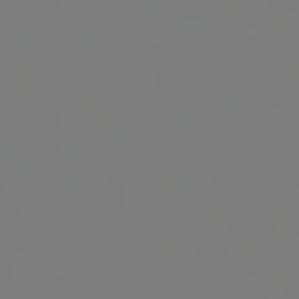

Iterations: 50, loss: -24.79016876220703, pred.: goldfish__carassius_auratus, conf.: [0.99999964]


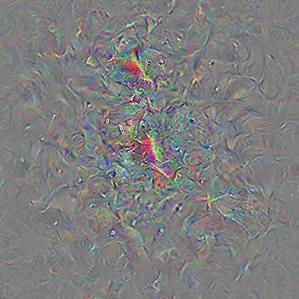

Iterations: 100, loss: -40.61577224731445, pred.: goldfish__carassius_auratus, conf.: [1.]


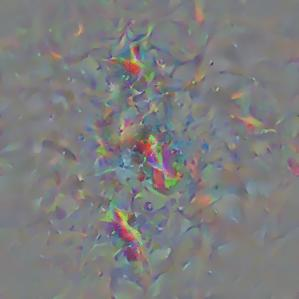

Iterations: 150, loss: -47.0955924987793, pred.: goldfish__carassius_auratus, conf.: [1.]


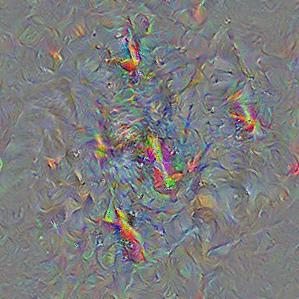

Iterations: 200, loss: -43.26985168457031, pred.: goldfish__carassius_auratus, conf.: [1.]


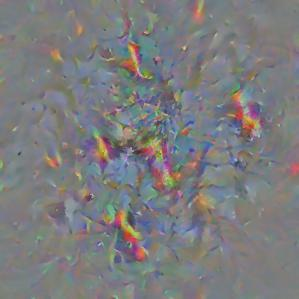

Iterations: 250, loss: -45.09288787841797, pred.: goldfish__carassius_auratus, conf.: [1.]


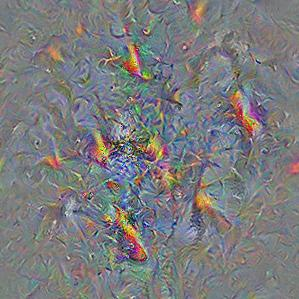

Iterations: 300, loss: -48.97669219970703, pred.: goldfish__carassius_auratus, conf.: [1.]


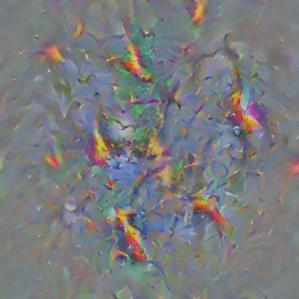

Iterations: 350, loss: -52.38066864013672, pred.: goldfish__carassius_auratus, conf.: [1.]


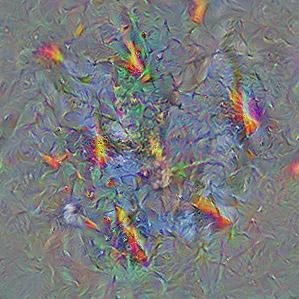

Iterations: 400, loss: -48.75847625732422, pred.: goldfish__carassius_auratus, conf.: [1.]


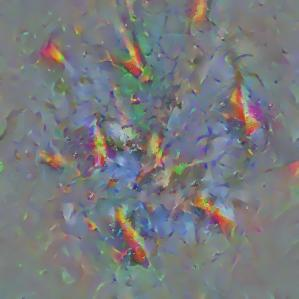

Iterations: 450, loss: -58.59209060668945, pred.: goldfish__carassius_auratus, conf.: [1.]


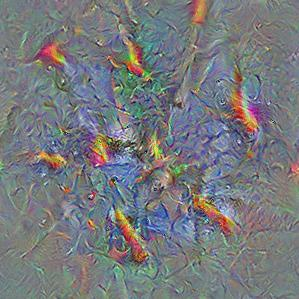

Iterations: 500, loss: -58.80984878540039, pred.: goldfish__carassius_auratus, conf.: [1.]


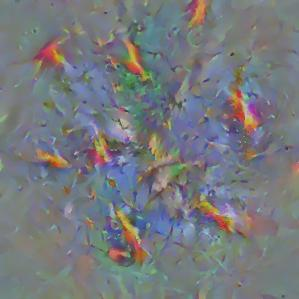

Iterations: 550, loss: -53.575050354003906, pred.: goldfish__carassius_auratus, conf.: [1.]


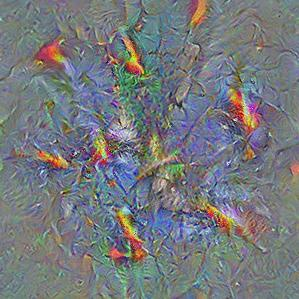

Iterations: 600, loss: -59.12294387817383, pred.: goldfish__carassius_auratus, conf.: [1.]


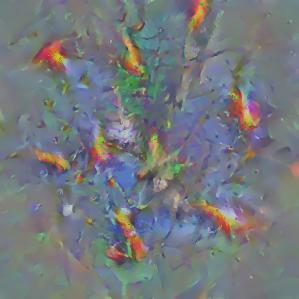

Iterations: 650, loss: -44.55072021484375, pred.: goldfish__carassius_auratus, conf.: [1.]


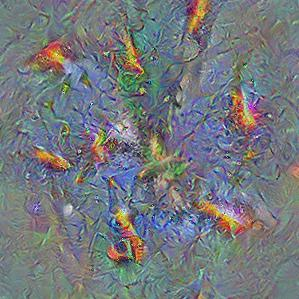

Iterations: 700, loss: -53.32147216796875, pred.: goldfish__carassius_auratus, conf.: [1.]


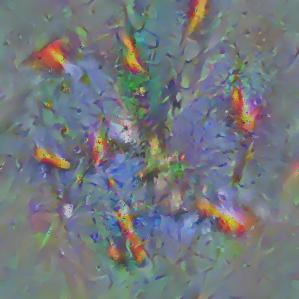

Iterations: 750, loss: -47.78840255737305, pred.: goldfish__carassius_auratus, conf.: [1.]


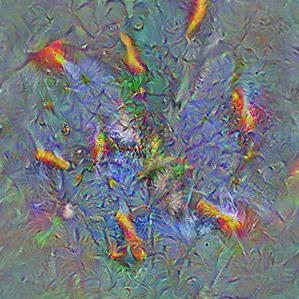

Iterations: 800, loss: -64.48573303222656, pred.: goldfish__carassius_auratus, conf.: [1.]


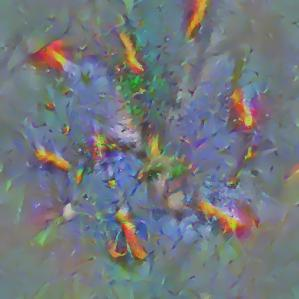

Iterations: 850, loss: -65.4998550415039, pred.: goldfish__carassius_auratus, conf.: [1.]


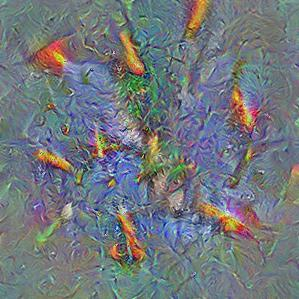

Iterations: 900, loss: -74.37641143798828, pred.: goldfish__carassius_auratus, conf.: [1.]


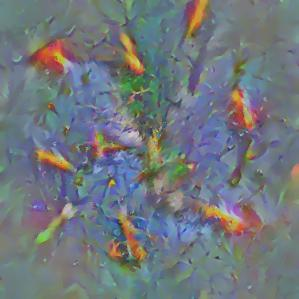

Iterations: 950, loss: -54.99101638793945, pred.: goldfish__carassius_auratus, conf.: [1.]


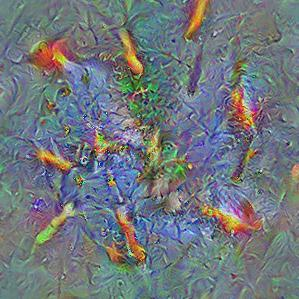

Iterations: 1000, loss: -63.90900421142578, pred.: goldfish__carassius_auratus, conf.: [1.]


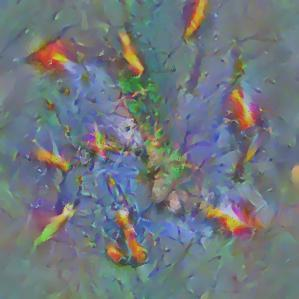

Iterations: 1050, loss: -57.42629623413086, pred.: goldfish__carassius_auratus, conf.: [1.]


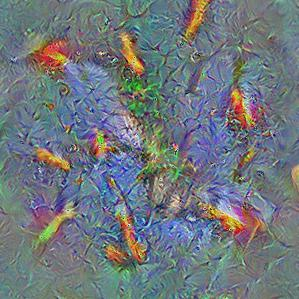

Iterations: 1100, loss: -67.34274291992188, pred.: goldfish__carassius_auratus, conf.: [1.]


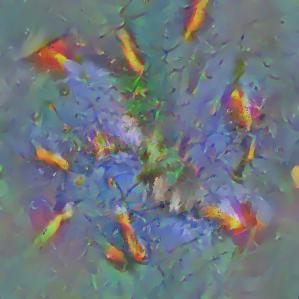

Iterations: 1150, loss: -66.29825592041016, pred.: goldfish__carassius_auratus, conf.: [1.]


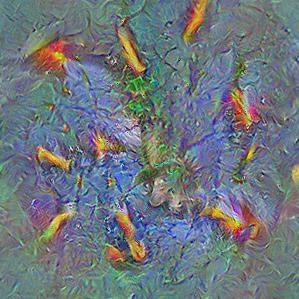

Iterations: 1200, loss: -65.80792236328125, pred.: goldfish__carassius_auratus, conf.: [1.]


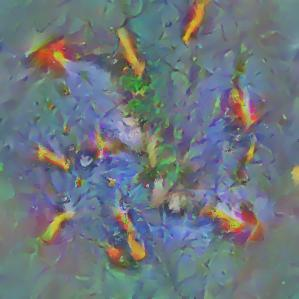

Iterations: 1250, loss: -53.04446029663086, pred.: goldfish__carassius_auratus, conf.: [1.]


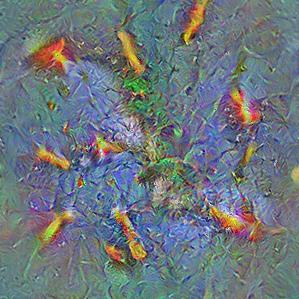

Iterations: 1300, loss: -62.19154357910156, pred.: goldfish__carassius_auratus, conf.: [1.]


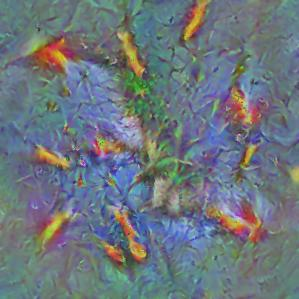

Iterations: 1350, loss: -60.51675796508789, pred.: goldfish__carassius_auratus, conf.: [1.]


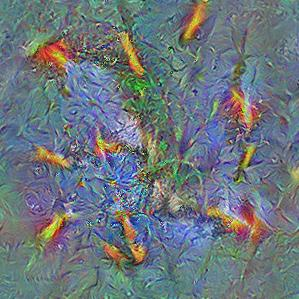

Iterations: 1400, loss: -75.58674621582031, pred.: goldfish__carassius_auratus, conf.: [1.]


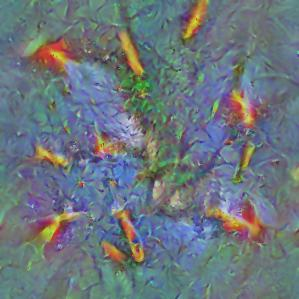

Iterations: 1450, loss: -61.60206985473633, pred.: goldfish__carassius_auratus, conf.: [1.]


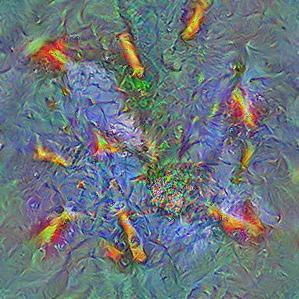

Iterations: 1500, loss: -64.44156646728516, pred.: goldfish__carassius_auratus, conf.: [1.]


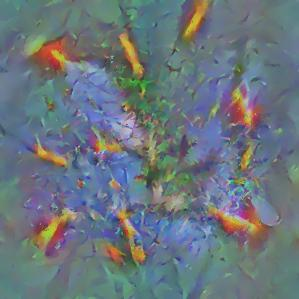

Iterations: 1550, loss: -56.284053802490234, pred.: goldfish__carassius_auratus, conf.: [1.]


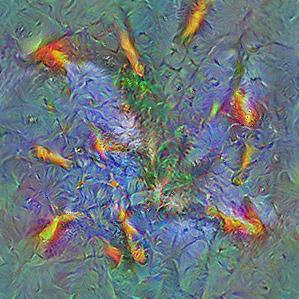

Iterations: 1600, loss: -71.38215637207031, pred.: goldfish__carassius_auratus, conf.: [1.]


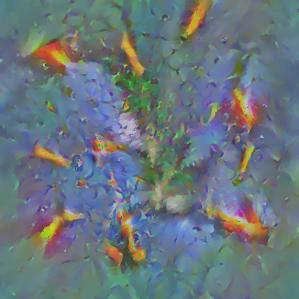

Iterations: 1650, loss: -66.64656829833984, pred.: goldfish__carassius_auratus, conf.: [1.]


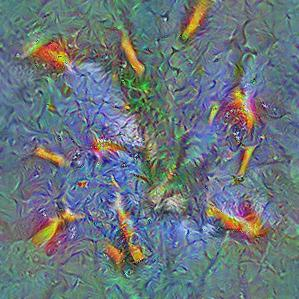

Iterations: 1700, loss: -68.45729064941406, pred.: goldfish__carassius_auratus, conf.: [1.]


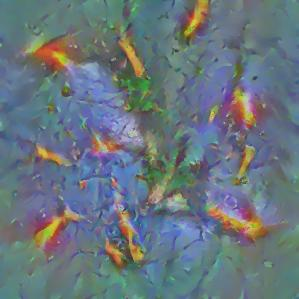

Iterations: 1750, loss: -59.0704231262207, pred.: goldfish__carassius_auratus, conf.: [1.]


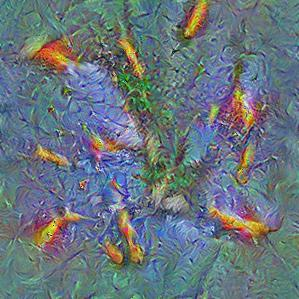

Iterations: 1800, loss: -65.84038543701172, pred.: goldfish__carassius_auratus, conf.: [1.]


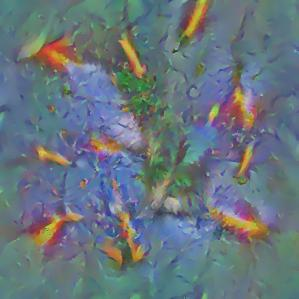

Iterations: 1850, loss: -62.29702377319336, pred.: goldfish__carassius_auratus, conf.: [1.]


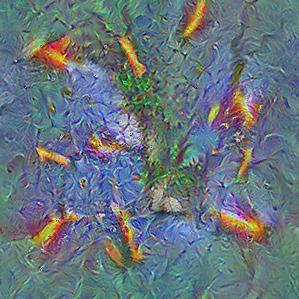

Iterations: 1900, loss: -72.2305679321289, pred.: goldfish__carassius_auratus, conf.: [1.]


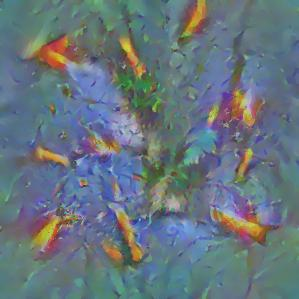

Iterations: 1950, loss: -55.5423469543457, pred.: goldfish__carassius_auratus, conf.: [1.]


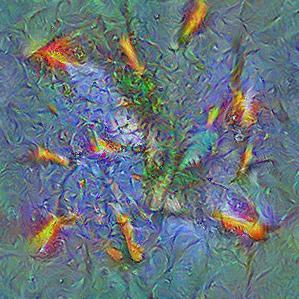

(1, 'goldfish__carassius_auratus', 1.0)


In [12]:
noise = gray_square(299)
img = gradient_ascent(noise, 1, f1)